In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from copy import deepcopy
import os
import os.path as op
import sys
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

loc = 'workstation'
if loc == 'workstation':
    wd = 'C:/Users/sammirc/Desktop/postdoc/tuningcurves'
elif loc == 'laptop':
    wd = '/Users/sammichekroud/Desktop/postdoc/tuningcurves'
sys.path.insert(0, op.join(wd, 'analysis', 'tools'))
os.chdir(wd)
from funcs import getSubjectInfo
from TuningCurveFuncs import makeTuningCurve, getTuningCurve_FullSpace, createFeatureBins, visualise_FeatureBins

os.chdir(wd)
subs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
subs = np.array([         4, 5, 6, 7, 8, 9,     11, 12, 13, 14, 15, 16, 17, 18,     20, 21, 22,     24, 25, 26])
#1,2,3,10,19 all have only 1 session. 23 something wrong in the second session, completely unusable eeg data due to serious noise
nsubs = subs.size
#get bin structure for data we want to load in
weightTrials = True #whether trial contributions to mean activity for a reference bin are weighted by distance from the bin centre
# binstep 4  options for binwidth: 11, 16, 22
# binstep 15 options for binwidth: 10, 15, 22
binstep, binwidth = 4, 22
# binstep, binwidth = 4, 11
# binstep, binwidth = 15, 22

times = np.load(op.join(wd, 'data', 'tuningcurves', '500hz', 'times_500hz.npy'))
model_settings = np.load(op.join(wd, 'data', 'tuningcurves', '500hz', 'parameter_fits', 'no_smoothing', 'model_settings.npy'), allow_pickle=True)
ntimes = times.size
nitems = 2 #two items are presented in the array, we 'decode' both
nparams = 2 #2 params as we get a beta and tvalue for glmfit and fitparam + tvalue (param/se) for optfit

nbins, binmids, binstarts, binends = createFeatureBins(binstep = binstep, binwidth = binwidth,
                                                       feature_start = -90+binstep, feature_end = 90)

In [2]:
model_settings

array({'smooth_alphas': False, 'smooth_distances': False, 'smoothing': 10, 'constrain_alpha': True, 'minmax_stage1': True, 'minmax_designmatrix_stage2': True},
      dtype=object)

In [3]:
#read in data
subcount = -1
print(f'loading in {nsubs} participants')
prec   = np.zeros(shape = [nsubs, nitems, nparams, ntimes]) * np.nan
ampglm = np.zeros(shape = [nsubs, nitems, nparams, ntimes]) * np.nan
ampopt = np.zeros(shape = [nsubs, nitems, nparams, ntimes]) * np.nan
for i in subs:
    subcount +=1
    #print(f'working on ppt {subcount+1}/{subs.size}')
    p = np.load(op.join(wd, 'data', 'tuningcurves', '500hz', 'parameter_fits', 'no_smoothing',
                f's{i}_ParamFits_precision_binstep{binstep}_binwidth{binwidth}.npy'))
    
    aglm = np.load(op.join(wd, 'data', 'tuningcurves', '500hz', 'parameter_fits', 'no_smoothing',
            f's{i}_ParamFits_amplitude_binstep{binstep}_binwidth{binwidth}_glmfit.npy'))

    aopt = np.load(op.join(wd, 'data', 'tuningcurves', '500hz', 'parameter_fits', 'no_smoothing',
            f's{i}_ParamFits_amplitude_binstep{binstep}_binwidth{binwidth}_optfit.npy'))
    
    prec[subcount] = np.nanmean(p, axis=1) #average across trials
    ampglm[subcount] = np.nanmean(aglm, axis=1)
    ampopt[subcount] = np.nanmean(aopt, axis=1)
print('done')

loading in 20 participants
done


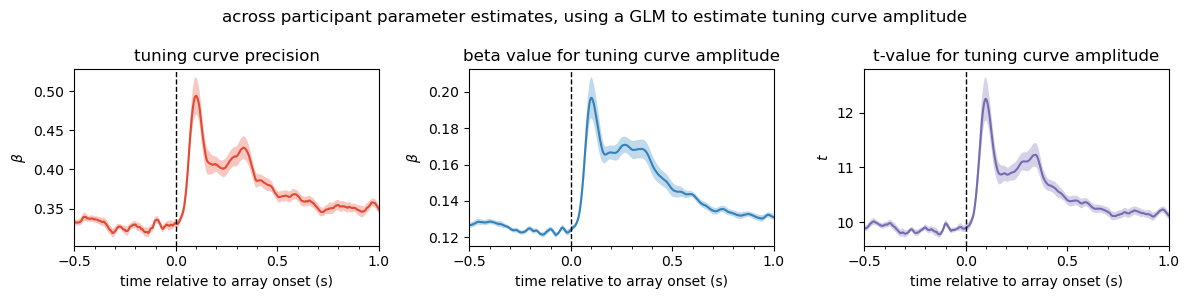

In [4]:
pm = np.nanmean(np.nanmean(prec, axis=1), axis=0) #average across items then average across participants
psem = sp.stats.sem(np.nanmean(prec, axis=1), axis=0, ddof=0, nan_policy='omit') #average across items then get sem per time point

glmb = np.nanmean(np.nanmean(ampglm, axis=1), axis=0) #average across items then across ppts
glmsem = sp.stats.sem(np.nanmean(ampglm, axis=1), axis=0, ddof=0, nan_policy='omit') #get std err per time point for both beta and t values


fig=plt.figure(figsize=[12,3])
ax=fig.add_subplot(131)
ax.plot(times, pm[0], lw = 1.5, color = '#e34a33')
ax.fill_between(times,
                np.add(pm[0], psem[0]),
                np.subtract(pm[0], psem[0]),
                alpha=0.3, color='#e34a33', edgecolor=None)
ax.set_ylabel('$\\beta$')
ax.set_xlabel('time relative to array onset (s)')
ax.set_title(f'tuning curve precision')
ax.axvline(0, ls = 'dashed', lw = 1, color='k')
ax.set_xlim([-0.5, 1])
ax.set_xticks(np.arange(-0.5, 1.5, 0.5))
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True)
ax = fig.add_subplot(132)
ax.plot(times, glmb[0], lw = 1.5, color='#3182bd')
ax.fill_between(times, 
                np.add(glmb[0], glmsem[0]),
                np.subtract(glmb[0], glmsem[0]),
                alpha = 0.3, color = '#3182bd', edgecolor=None)
ax.set_ylabel('$\\beta$')
ax.set_xlabel('time relative to array onset (s)')
ax.set_title(f'beta value for tuning curve amplitude')
ax.set_xticks(np.arange(-0.5, 1.5, 0.5))
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True)
ax.set_xlim([-0.5, 1])
ax.axvline(0, ls = 'dashed', lw = 1, color='k')
ax = fig.add_subplot(133)
ax.plot(times, glmb[1], lw = 1.5, color='#756bb1')
ax.fill_between(times, 
                np.add(glmb[1], glmsem[1]),
                np.subtract(glmb[1], glmsem[1]),
                alpha = 0.3, color = '#756bb1', edgecolor=None)
ax.set_ylabel('$t$')
ax.set_xlabel('time relative to array onset (s)')
ax.set_xticks(np.arange(-0.5, 1.5, 0.5))
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True)
ax.axvline(0, ls = 'dashed', lw = 1, color='k')
ax.set_xlim([-0.5, 1])
ax.set_title(f't-value for tuning curve amplitude')
fig.suptitle('across participant parameter estimates, using a GLM to estimate tuning curve amplitude')
fig.tight_layout()

<font color='red'>

for the plots above, a first stage is performed to estimate the precision of the EEG tuning curve, separately for each item in the array, trial in the task, and time point in the response. The distances are min-max scaled (between 0 and 1) across orientations in this phase, to allow better fitting of shape.

In the second stage, the estimated precision is smoothed lightly across time within each trial. We then use this precision in the second stage to estimate the amplitude of the tuning curve at each timepoint, with the following:

$d_{pos} \sim \beta * MinMax(precision * \theta)$, where the estimated $\beta$ is the modelled amplitude of the tuning curve at a given timepoint

where, $d_{pos}$ represents the positive distances across orientation (i.e. distance + abs(min(distance))).

MinMax represents a scaling of the vector distances, where $MinMax(x) = (x - min(x))/(max(x)-min(x))$. This rescales a vector between 0 and 1, based on its minimum and maximum values. This rescales the cosine shape that is being fit such that it varies in height between 0-1, and can scale appropriately to fit the amplitude of the tuning curve.

As this is fit as a glm, we get both a beta value and a t-value for the estimated amplitude at each time point. We can visualise the timecourses of these across time.

<font color='blue'>

alternatively, we can use an optimisation routine to estimate the tuning curve amplitude on the exact same data, and get beta weights + t-values for the recovered parameters. In this pipeline, we do not need to minmax scale a design matrix. This simply uses an optimisation routine to fit the curve $d_{pos} = amplitude * cos(precision * \theta)$, where the precision is taken from the previous estimation stage.

We get a recovered parameter for amplitude, and its covariance, thus can calculate the t-value for the optimised parameter too, and plot the same figures as below for the alternative pipeline.

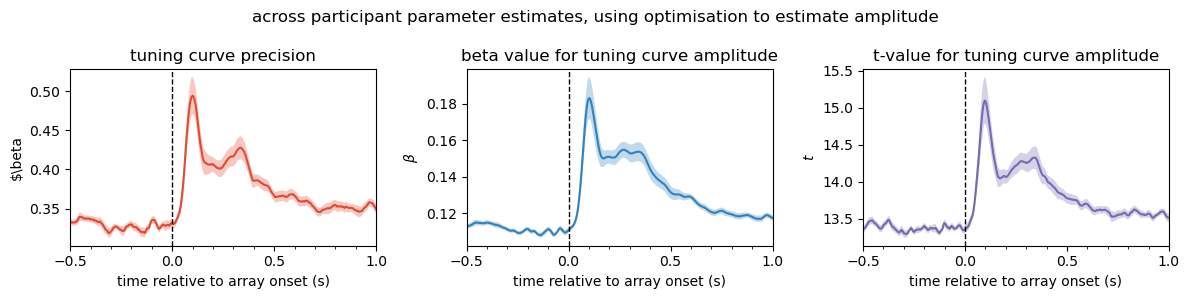

In [5]:
pm = np.nanmean(np.nanmean(prec, axis=1), axis=0) #average across items then average across participants
psem = sp.stats.sem(np.nanmean(prec, axis=1), axis=0, ddof=0, nan_policy='omit') #average across items then get sem per time point

glmb = np.nanmean(np.nanmean(ampopt, axis=1), axis=0) #average across items then across ppts
glmsem = sp.stats.sem(np.nanmean(ampopt, axis=1), axis=0, ddof=0, nan_policy='omit') #get std err per time point for both beta and t values


fig=plt.figure(figsize=[12,3])
ax=fig.add_subplot(131)
ax.plot(times, pm[0], lw = 1.5, color = '#e34a33')
ax.fill_between(times,
                np.add(pm[0], psem[0]),
                np.subtract(pm[0], psem[0]),
                alpha=0.3, color='#e34a33', edgecolor=None)
ax.set_ylabel('$\\beta')
ax.set_xlabel('time relative to array onset (s)')
ax.set_xticks(np.arange(-0.5, 1.5, 0.5))
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True)
ax.axvline(0, ls = 'dashed', lw = 1, color='k')
ax.set_xlim([-0.5, 1])
ax.set_title(f'tuning curve precision')
ax = fig.add_subplot(132)
ax.plot(times, glmb[0], lw = 1.5, color='#3182bd')
ax.fill_between(times, 
                np.add(glmb[0], glmsem[0]),
                np.subtract(glmb[0], glmsem[0]),
                alpha = 0.3, color = '#3182bd', edgecolor=None)
ax.set_ylabel('$\\beta$')
ax.set_xlabel('time relative to array onset (s)')
ax.set_xticks(np.arange(-0.5, 1.5, 0.5))
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True)
ax.axvline(0, ls = 'dashed', lw = 1, color='k')
ax.set_xlim([-0.5, 1])
ax.set_title(f'beta value for tuning curve amplitude')
ax = fig.add_subplot(133)
ax.plot(times, glmb[1], lw = 1.5, color='#756bb1')
ax.fill_between(times, 
                np.add(glmb[1], glmsem[1]),
                np.subtract(glmb[1], glmsem[1]),
                alpha = 0.3, color = '#756bb1', edgecolor=None)
ax.set_ylabel('$t$')
ax.set_xlabel('time relative to array onset (s)')
ax.set_xticks(np.arange(-0.5, 1.5, 0.5))
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True)
ax.axvline(0, ls = 'dashed', lw = 1, color='k')
ax.set_xlim([-0.5, 1])
ax.set_title(f't-value for tuning curve amplitude')
fig.suptitle('across participant parameter estimates, using optimisation to estimate amplitude')
fig.tight_layout()

<font color='red'>

overall, these are largely quite similar in this regard. For the glm fitting pipeline, the recovered amplitude parameter is much more stable with precision constrained to be greater than 0.001 (so that $cos(theta * precision)$ is never uniformly one across orientation).

<font color = 'blue'>

#### compare the consequence of different binsteps on tuning curve precision and amplitude

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/sammirc/Desktop/postdoc/tuningcurves\\data\\tuningcurves\\500hz\\parameter_fits\\twostage_alphaminmaxfit\\s4_ParamFits_precision_binstep15_binwidth22.npy'

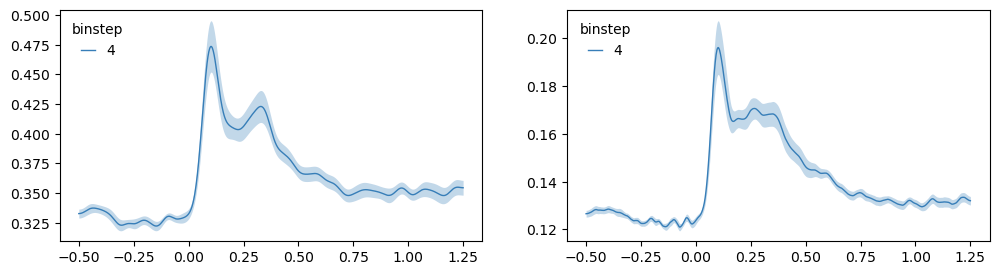

In [6]:
#read in data
fig = plt.figure(figsize = [12, 3])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

subcount = -1

combos = [(4, 22), (15, 22)] #binstep/binwidth combinations
cols = ['#377eb8', '#984ea3']
combcount = -1
for combo in combos:
    combcount += 1
    binstep, binwidth = combo[0], combo[1]

    prec   = np.zeros(shape = [nsubs, nitems, nparams, ntimes]) * np.nan
    ampglm = np.zeros(shape = [nsubs, nitems, nparams, ntimes]) * np.nan
    subcount = -1
    for i in subs:
        subcount +=1
        #print(f'working on ppt {subcount+1}/{subs.size}')
        p = np.load(op.join(wd, 'data', 'tuningcurves', '500hz', 'parameter_fits', 'twostage_alphaminmaxfit',
                f's{i}_ParamFits_precision_binstep{binstep}_binwidth{binwidth}.npy'))
    
        aglm = np.load(op.join(wd, 'data', 'tuningcurves', '500hz', 'parameter_fits', 'twostage_alphaminmaxfit',
                f's{i}_ParamFits_amplitude_binstep{binstep}_binwidth{binwidth}_glmfit.npy'))
        
        prec[subcount] = np.nanmean(p, axis=1) #average across trials
        ampglm[subcount] = np.nanmean(aglm, axis=1)

    prec_mean = np.nanmean(np.nanmean(prec, axis=1), axis=0) #average across items then average across participants
    prec_sem  = sp.stats.sem(np.nanmean(prec, axis=1), axis=0, ddof=0, nan_policy='omit') #average across items then get sem per time point
    
    amp_mean = np.nanmean(np.nanmean(ampglm, axis=1), axis=0) #average across items then across ppts
    amp_sem = sp.stats.sem(np.nanmean(ampglm, axis=1), axis=0, ddof=0, nan_policy='omit') #get std err per time point for both beta and t values

    ax1.plot(times, prec_mean[0], lw = 1, color = cols[combcount], label = str(binstep))
    ax1.fill_between(times, np.add(prec_mean[0], prec_sem[0]), np.subtract(prec_mean[0], prec_sem[0]), lw = 0, edgecolor = None, color = cols[combcount], alpha = 0.3)

    ax2.plot(times, amp_mean[0], lw = 1, color = cols[combcount], label = str(binstep))
    ax2.fill_between(times, np.add(amp_mean[0], amp_sem[0]), np.subtract(amp_mean[0], amp_sem[0]), lw = 0, edgecolor = None, color = cols[combcount], alpha = 0.3)

    ax1.legend(loc = 'upper left', frameon=False, handlelength = 1, title = 'binstep')
    ax2.legend(loc = 'upper left', frameon = False, handlelength = 1, title = 'binstep')

ax1.set_title('tuning curve precision', fontsize = 10)
ax2.set_title('tuning curve amplitude', fontsize = 10)

for ax in [ax1, ax2]:
    ax.axvline(0, ls = 'dashed', lw = 0.75, color='k')
    ax.set_xticks(np.arange(-0.5, 1.5, 0.5))
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True)
    ax.set_xlabel('time relative to array onset (s)')
    ax.set_xlim([-0.3, 1])
fig.tight_layout()